In [1]:
!pip install --upgrade numpy
# Install RDKit
!pip install rdkit-pypi

# Install TensorFlow which includes Keras
!pip install tensorflow

# Optional: upgrade pip to avoid dependency issues
!pip install --upgrade pip


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-

In [9]:
# Import libraries
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import time
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, AllChem, rdMolDescriptors, rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.AtomPairs import Pairs, Torsions

# Try importing rdMolStandardize with fallback
try:
    from rdkit.Chem import rdMolStandardize
except ImportError:
    try:
        from rdkit.Chem.rdMolStandardize import *
    except ImportError:
        print("Warning: rdMolStandardize not available - using basic sanitization only")
        rdMolStandardize = None

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline

# Set random seeds for reproducibility
import random
import tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Create output directory for models and visualizations
os.makedirs("fingerprint_comparison", exist_ok=True)

In [11]:
# Load data
print("Loading dataset...")
df = pd.read_csv("chembl_cdk5_ki.csv", index_col=0)
df = df.reset_index(drop=True)

Loading dataset...


Preparing dataset...
Dataset shape after preparation: (1038, 2)
pKi range: 4.10 to 9.50


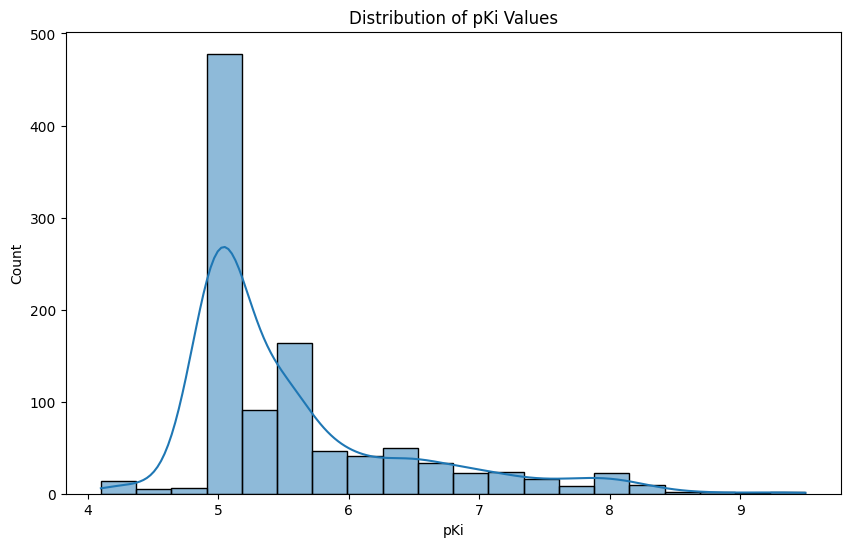

In [14]:

# Data cleaning and preparation
def clean_structure(smiles):
    """
    Clean chemical structures by:
    - Neutralizing charges
    - Removing salts
    - Taking largest fragment

    Parameters
    ----------
    smiles : str
        SMILES string representation of molecule

    Returns
    -------
    str or None
        Standardized SMILES string, or None if conversion fails
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Basic sanitization
        mol.UpdatePropertyCache(strict=False)
        Chem.SanitizeMol(mol)

        # Advanced standardization if available
        if rdMolStandardize is not None:
            try:
                # Standardizer
                normalizer = rdMolStandardize.Normalizer()
                mol = normalizer.normalize(mol)

                # Remove salts and fragments
                fragment_remover = rdMolStandardize.LargestFragmentChooser()
                mol = fragment_remover.choose(mol)

                # Charge neutralization
                uncharger = rdMolStandardize.Uncharger()
                mol = uncharger.uncharge(mol)
            except Exception as e:
                print(f"Standardization warning: {e}")

        return Chem.MolToSmiles(mol)
    except Exception as e:
        print(f"Error in structure cleaning: {e}")
        return None

# Clean and prepare the dataset
print("Preparing dataset...")
df["Standard Value"] = pd.to_numeric(df["Standard Value"], errors="coerce")
df = df.dropna(subset=["Standard Value", "Smiles"])

# Convert to pKi values (-log10 of Ki in M)
df["pKi"] = -np.log10(df["Standard Value"] * 1e-9)

# Clean structures
df["Cleaned_Smiles"] = df["Smiles"].apply(clean_structure)
df = df.dropna(subset=["Cleaned_Smiles"])
# Keep necessary columns
chembl_df = df[["Smiles", "pKi"]]

print(f"Dataset shape after preparation: {chembl_df.shape}")
print(f"pKi range: {chembl_df['pKi'].min():.2f} to {chembl_df['pKi'].max():.2f}")


# Display distribution of pKi values
plt.figure(figsize=(10, 6))
sns.histplot(data=chembl_df, x="pKi", bins=20, kde=True)
plt.title("Distribution of pKi Values")
plt.xlabel("pKi")
plt.ylabel("Count")
plt.savefig("fingerprint_comparison/pki_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [15]:
# Define a comprehensive fingerprint generation function
def generate_fingerprint(smiles, fp_type="maccs", radius=2, n_bits=2048):
    """
    Generate molecular fingerprints of different types.

    Parameters
    ----------
    smiles : str
        SMILES string of the molecule
    fp_type : str
        Type of fingerprint: 'maccs', 'morgan', or 'topological'
    radius : int
        Radius for Morgan fingerprints
    n_bits : int
        Number of bits for Morgan and topological fingerprints

    Returns
    -------
    numpy.ndarray
        Fingerprint as a numpy array
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not convert SMILES to molecule: {smiles}")
            return np.zeros(n_bits if fp_type != "maccs" else 167)

        if fp_type == "maccs":
            return np.array(MACCSkeys.GenMACCSKeys(mol))
        elif fp_type == "morgan":
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
            return np.array(fp)
        elif fp_type == "topological":
            fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
            return np.array(fp)
        else:
            print(f"Warning: Unknown fingerprint type '{fp_type}'. Using MACCS keys.")
            return np.array(MACCSkeys.GenMACCSKeys(mol))
    except Exception as e:
        print(f"Error generating fingerprint for {smiles}: {e}")
        return np.zeros(n_bits if fp_type != "maccs" else 167)


In [16]:
# Function to create and train neural network models
def build_nn_model(input_dim, hidden1=64, hidden2=32, dropout_rate=0.2, lr=0.001):
    """
    Build a neural network model for regression.

    Parameters
    ----------
    input_dim : int
        Dimension of input features
    hidden1 : int
        Number of neurons in first hidden layer
    hidden2 : int
        Number of neurons in second hidden layer
    dropout_rate : float
        Dropout rate for regularization
    lr : float
        Learning rate for Adam optimizer

    Returns
    -------
    tf.keras.models.Sequential
        Compiled neural network model
    """
    model = Sequential([
        Dense(hidden1, activation='relu', input_dim=input_dim, name='layer1'),
        Dropout(dropout_rate),
        Dense(hidden2, activation='relu', name='layer2'),
        Dropout(dropout_rate),
        Dense(1, activation='linear', name='output')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )

    return model

In [20]:
# Function to train and evaluate a model with a specific fingerprint type
def train_evaluate_model(fp_type, radius=2, n_bits=2048, epochs=50, batch_size=32):
    """
    Train and evaluate a model using a specific fingerprint type.

    Parameters
    ----------
    fp_type : str
        Type of fingerprint: 'maccs', 'morgan', or 'topological'
    radius : int
        Radius for Morgan fingerprints
    n_bits : int
        Number of bits for Morgan and topological fingerprints
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training

    Returns
    -------
    dict
        Dictionary containing model, history, and performance metrics
    """
    print(f"\n{'='*50}")
    print(f"Training model with {fp_type.upper()} fingerprints")
    if fp_type == 'morgan':
        print(f"Radius: {radius}, Bits: {n_bits}")
    print(f"{'='*50}")

    # Generate fingerprints
    start_time = time.time()
    if fp_type == 'maccs':
        chembl_df['fingerprints'] = chembl_df['Smiles'].apply(
            lambda x: generate_fingerprint(x, fp_type='maccs')
        )
    elif fp_type == 'morgan':
        chembl_df['fingerprints'] = chembl_df['Smiles'].apply(
            lambda x: generate_fingerprint(x, fp_type='morgan', radius=radius, n_bits=n_bits)
        )
    elif fp_type == 'topological':
        chembl_df['fingerprints'] = chembl_df['Smiles'].apply(
            lambda x: generate_fingerprint(x, fp_type='topological', n_bits=n_bits)
        )

    print(f"Time to generate fingerprints: {time.time() - start_time:.2f} seconds")
    # Split data
    X = np.array(list(chembl_df['fingerprints']))
    y = chembl_df['pKi'].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    # Build model
    input_dim = X_train.shape[1]
    model = build_nn_model(input_dim=input_dim)

    # Callbacks
    model_path = f"fingerprint_comparison/model_{fp_type}"
    if fp_type == 'morgan':
        model_path += f"_r{radius}"
    model_path += ".h5"

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate R² score
    r2 = metrics.r2_score(y_test, y_pred)
    print(f"R² Score: {r2:.4f}")

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves - {fp_type.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title(f'Predicted vs Actual - {fp_type.upper()} (R²={r2:.4f})')
    plt.xlabel('Actual pKi')
    plt.ylabel('Predicted pKi')

    plt.tight_layout()
    plt.savefig(f"fingerprint_comparison/performance_{fp_type}{'' if fp_type != 'morgan' else f'_r{radius}'}.png",
                dpi=300, bbox_inches="tight")
    plt.show()

    return {
        'model': model,
        'history': history.history,
        'metrics': {
            'mse': test_mse,
            'mae': test_mae,
            'r2': r2
        },
        'fingerprint_type': fp_type,
        'predictions': y_pred,
        'actual': y_test
    }


In [21]:
# Train models with different fingerprint types
results = {}


Training model with MACCS fingerprints
Time to generate fingerprints: 1.74 seconds
Training set: (830, 167), Test set: (208, 167)
Epoch 1/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.9777 - mae: 5.2359 - mse: 28.9777

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 28.2869 - mae: 5.1572 - mse: 28.2869 - val_loss: 6.2630 - val_mae: 2.2355 - val_mse: 6.2630
Epoch 2/50
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0339 - mae: 1.8460 - mse: 5.0339 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9435 - mae: 1.8244 - mse: 4.9435 - val_loss: 1.7769 - val_mae: 1.0596 - val_mse: 1.7769
Epoch 3/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4870 - mae: 1.5329 - mse: 3.4870 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4517 - mae: 1.5213 - mse: 3.4517 - val_loss: 1.6132 - val_mae: 0.9855 - val_mse: 1.6132
Epoch 4/50
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2074 - mae: 1.4110 - mse: 3.2074 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1388 - mae: 1.3985 - mse: 3.1388 - val_loss: 1.2183 - val_mae: 0.8896 - val_mse: 1.2183
Epoch 5/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.6987 - mae: 1.3767 - mse: 2.6987

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4299 - mae: 1.2670 - mse: 2.4299 - val_loss: 1.1870 - val_mae: 0.8317 - val_mse: 1.1870
Epoch 6/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 3.1185 - mae: 1.4523 - mse: 3.1185

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2553 - mae: 1.1931 - mse: 2.2553 - val_loss: 0.9188 - val_mae: 0.7775 - val_mse: 0.9188
Epoch 7/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8565 - mae: 1.0793 - mse: 1.8565 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8682 - mae: 1.0833 - mse: 1.8682 - val_loss: 0.8732 - val_mae: 0.7324 - val_mse: 0.8732
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8361 - mae: 1.0801 - mse: 1.8361  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8323 - mae: 1.0791 - mse: 1.8323 - val_loss: 0.8351 - val_mae: 0.7068 - val_mse: 0.8351
Epoch 9/50
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5787 - mae: 0.9847 - mse: 1.5787  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5966 - mae: 0.9899 - mse: 1.5966 - val_loss: 0.7680 - val_mae: 0.6811 - val_mse: 0.7680
Epoch 10/50
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6200 - mae: 1.0044 - mse: 1.6200 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6106 - mae: 0.9992 - mse: 1.6106 - val_loss: 0.7649 - val_mae: 0.6941 - val_mse: 0.7649
Epoch 11/50
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7307 - mae: 1.0545 - mse: 1.7307 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7306 - mae: 1.0437 - mse: 1.7306 - val_loss: 0.7336 - val_mae: 0.6772 - val_mse: 0.7336
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6261 - mae: 0.9928 - mse: 1.6261 - val_loss: 0.7761 - val_mae: 0.6612 - val_mse: 0.7761
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5448 - mae: 0.9898 - mse: 1.5448 - val_loss: 0.7727 - val_mae: 0.6556 - val_mse: 0.7727
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6024 - mae: 0.9811 - mse: 1.6024 - val_loss: 0.7454 - val_mae: 0.6482 - val_mse: 0.7454
Epoch 15/50
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4025 - mae: 0.9329 - mse: 1.4025  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4121 - mae: 0.9359 - mse: 1.4121 - val_loss: 0.7065 - val_mae: 0.6317 - val_mse: 0.7065
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4811 - mae: 0.9240 - mse: 1.4811 - val_loss: 0.7370 - val_mae: 0.6344 - val_mse: 0.7370
Epoch 17/50
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1977 - mae: 0.8504 - mse: 1.1977  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2168 - mae: 0.8532 - mse: 1.2168 - val_loss: 0.7059 - val_mae: 0.6253 - val_mse: 0.7059
Epoch 18/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4280 - mae: 0.9379 - mse: 1.4280 - val_loss: 0.7652 - val_mae: 0.6547 - val_mse: 0.7652
Epoch 19/50
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1370 - mae: 0.8395 - mse: 1.1370  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1625 - mae: 0.8467 - mse: 1.1625 - val_loss: 0.6482 - val_mae: 0.6191 - val_mse: 0.6482
Epoch 20/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1771 - mae: 0.8727 - mse: 1.1771 - val_loss: 0.6978 - val_mae: 0.6200 - val_mse: 0.6978
Epoch 21/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2228 - mae: 0.8763 - mse: 1.2228 - val_loss: 0.6936 - val_mae: 0.6183 - val_mse: 0.6936
Epoch 22/50
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1281 - mae: 0.8382 - mse: 1.1281 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1698 - mae: 0.8517 - mse: 1.1698 - val_loss: 0.6315 - val_mae: 0.6129 - val_mse: 0.6315
Epoch 23/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4564 - mae: 0.9247 - mse: 1.4564 - val_loss: 0.6508 - val_mae: 0.6088 - val_mse: 0.6508
Epoch 24/50
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5228 - mae: 0.9644 - mse: 1.5228  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4548 - mae: 0.9449 - mse: 1.4548 - val_loss: 0.6300 - val_mae: 0.6131 - val_mse: 0.6300
Epoch 25/50
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1654 - mae: 0.8565 - mse: 1.1654 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1780 - mae: 0.8604 - mse: 1.1780 - val_loss: 0.6257 - val_mae: 0.6132 - val_mse: 0.6257
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0561 - mae: 0.8016 - mse: 1.0561 - val_loss: 0.6681 - val_mae: 0.6047 - val_mse: 0.6681
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1091 - mae: 0.8333 - mse: 1.1091 - val_loss: 0.7246 - val_mae: 0.6246 - val_mse: 0.7246
Epoch 28/50
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3621 - mae: 0.9078 - mse: 1.3621  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3186 - mae: 0.8916 - mse: 1.3186 - val_loss: 0.6253 - val_mae: 0.5904 - val_mse: 0.6253
Epoch 29/50
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1610 - mae: 0.8648 - mse: 1.1610 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1695 - mae: 0.8586 - mse: 1.1695 - val_loss: 0.5819 - val_mae: 0.5837 - val_mse: 0.5819
Epoch 30/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3021 - mae: 0.9228 - mse: 1.3021 - val_loss: 0.6411 - val_mae: 0.5771 - val_mse: 0.6411
Epoch 31/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3779 - mae: 0.9043 - mse: 1.3779 - val_loss: 0.6395 - val_mae: 0.5851 - val_mse: 0.6395
Epoch 32/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9956 - mae: 0.7759 - mse: 0.9956 - val_loss: 0.6589 - val_mae: 0.5914 - val_mse: 0.6589
Epoch 33/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2548 - mae: 0.8892 - mse: 1.2548 - val_loss: 0.6559 - val_mae: 0.5877 - val_mse: 0.6559
Epoch 34/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1321 - mae: 0.8145 - mse: 1.1321 - val_loss: 0.6319 - val_mae: 0.5740 - val_mse: 0.6319
Epoch 35/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1440 - mae: 0.8502 - mse: 1.1440 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1466 - mae: 0.8505 - mse: 1.1466 - val_loss: 0.5715 - val_mae: 0.5721 - val_mse: 0.5715
Epoch 36/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1037 - mae: 0.8178 - mse: 1.1037 - val_loss: 0.5890 - val_mae: 0.5686 - val_mse: 0.5890
Epoch 37/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0302 - mae: 0.7820 - mse: 1.0302 - val_loss: 0.6465 - val_mae: 0.5882 - val_mse: 0.6465
Epoch 38/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1047 - mae: 0.8485 - mse: 1.1047 - val_loss: 0.6277 - val_mae: 0.5791 - val_mse: 0.6277
Epoch 39/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9630 - mae: 0.7770 - mse: 0.9630 - val_loss: 0.6173 - val_mae: 0.5728 - val_mse: 0.6173
Epoch 40/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9946 - mae: 0.7934 - mse: 0.9946 - val_loss: 0.6214 - val_mae: 0.5772 - val_mse: 0.6214
Epoch 41/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0159 - mae: 0.7767 - mse: 1.0159 - val_loss: 0.5898 - v

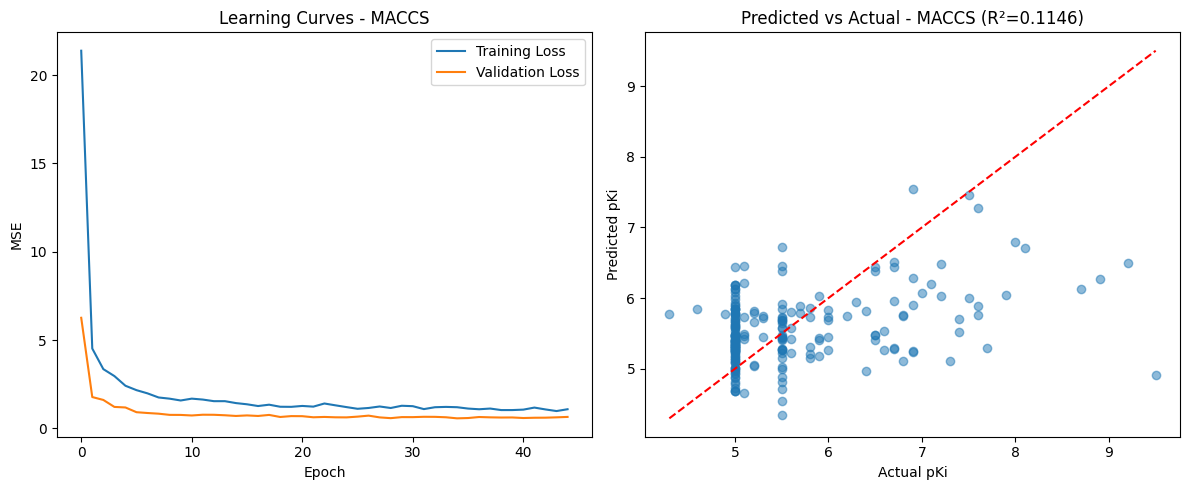


Training model with MORGAN fingerprints
Radius: 2, Bits: 2048


[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerator
[11:40:56] DEPRECATION WARNING: please use MorganGenerat

Time to generate fingerprints: 1.47 seconds
Training set: (830, 2048), Test set: (208, 2048)
Epoch 1/50


[11:40:57] DEPRECATION WARNING: please use MorganGenerator
[11:40:57] DEPRECATION WARNING: please use MorganGenerator
[11:40:57] DEPRECATION WARNING: please use MorganGenerator
[11:40:57] DEPRECATION WARNING: please use MorganGenerator


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.0008 - mae: 4.9640 - mse: 26.0008

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 25.3446 - mae: 4.8818 - mse: 25.3446 - val_loss: 3.8994 - val_mae: 1.6453 - val_mse: 3.8994
Epoch 2/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4903 - mae: 1.4982 - mse: 3.4903

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4855 - mae: 1.4892 - mse: 3.4855 - val_loss: 1.5907 - val_mae: 0.9941 - val_mse: 1.5907
Epoch 3/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3174 - mae: 1.2234 - mse: 2.3174

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3194 - mae: 1.2238 - mse: 2.3194 - val_loss: 1.3056 - val_mae: 0.8666 - val_mse: 1.3056
Epoch 4/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8804 - mae: 1.0698 - mse: 1.8804

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8800 - mae: 1.0705 - mse: 1.8800 - val_loss: 1.2644 - val_mae: 0.8498 - val_mse: 1.2644
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4843 - mae: 0.9606 - mse: 1.4843

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4882 - mae: 0.9622 - mse: 1.4882 - val_loss: 0.9583 - val_mae: 0.7225 - val_mse: 0.9583
Epoch 6/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4981 - mae: 0.9709 - mse: 1.4981

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4985 - mae: 0.9720 - mse: 1.4985 - val_loss: 0.9391 - val_mae: 0.7056 - val_mse: 0.9391
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4846 - mae: 0.9714 - mse: 1.4846

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4762 - mae: 0.9685 - mse: 1.4762 - val_loss: 0.9308 - val_mae: 0.7125 - val_mse: 0.9308
Epoch 8/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1179 - mae: 0.8390 - mse: 1.1179

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1203 - mae: 0.8387 - mse: 1.1203 - val_loss: 0.8815 - val_mae: 0.6922 - val_mse: 0.8815
Epoch 9/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0733 - mae: 0.8007 - mse: 1.0733

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0919 - mae: 0.8076 - mse: 1.0919 - val_loss: 0.8647 - val_mae: 0.6802 - val_mse: 0.8647
Epoch 10/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0655 - mae: 0.8195 - mse: 1.0655

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0617 - mae: 0.8185 - mse: 1.0617 - val_loss: 0.8200 - val_mae: 0.6709 - val_mse: 0.8200
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0294 - mae: 0.7998 - mse: 1.0294 - val_loss: 0.8885 - val_mae: 0.7036 - val_mse: 0.8885
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0960 - mae: 0.8209 - mse: 1.0960 - val_loss: 0.8456 - val_mae: 0.6884 - val_mse: 0.8456
Epoch 13/50
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8284 - mae: 0.7211 - mse: 0.8284  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8686 - mae: 0.7363 - mse: 0.8686 - val_loss: 0.8034 - val_mae: 0.6482 - val_mse: 0.8034
Epoch 14/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8575 - mae: 0.7074 - mse: 0.8575

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8687 - mae: 0.7127 - mse: 0.8687 - val_loss: 0.8016 - val_mae: 0.6332 - val_mse: 0.8016
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8534 - mae: 0.7326 - mse: 0.8534 - val_loss: 0.8363 - val_mae: 0.6607 - val_mse: 0.8363
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8543 - mae: 0.7340 - mse: 0.8543 - val_loss: 0.8436 - val_mae: 0.6747 - val_mse: 0.8436
Epoch 17/50
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0026 - mae: 0.8022 - mse: 1.0026 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9498 - mae: 0.7813 - mse: 0.9498 - val_loss: 0.7872 - val_mae: 0.6560 - val_mse: 0.7872
Epoch 18/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9528 - mae: 0.7545 - mse: 0.9528 - val_loss: 0.8328 - val_mae: 0.6564 - val_mse: 0.8328
Epoch 19/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9200 - mae: 0.7490 - mse: 0.9200 - val_loss: 0.8572 - val_mae: 0.6708 - val_mse: 0.8572
Epoch 20/50
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7732 - mae: 0.7077 - mse: 0.7732 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7919 - mae: 0.7163 - mse: 0.7919 - val_loss: 0.7631 - val_mae: 0.6279 - val_mse: 0.7631
Epoch 21/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7409 - mae: 0.6879 - mse: 0.7409 - val_loss: 0.8690 - val_mae: 0.6845 - val_mse: 0.8690
Epoch 22/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8616 - mae: 0.7287 - mse: 0.8616 - val_loss: 0.8682 - val_mae: 0.6819 - val_mse: 0.8682
Epoch 23/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7451 - mae: 0.6775 - mse: 0.7451

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7500 - mae: 0.6797 - mse: 0.7500 - val_loss: 0.7463 - val_mae: 0.6274 - val_mse: 0.7463
Epoch 24/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7374 - mae: 0.6647 - mse: 0.7374

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7421 - mae: 0.6676 - mse: 0.7421 - val_loss: 0.7009 - val_mae: 0.6069 - val_mse: 0.7009
Epoch 25/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8341 - mae: 0.7206 - mse: 0.8341 - val_loss: 0.9351 - val_mae: 0.7020 - val_mse: 0.9351
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7917 - mae: 0.6978 - mse: 0.7917 - val_loss: 0.8448 - val_mae: 0.6558 - val_mse: 0.8448
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9395 - mae: 0.7607 - mse: 0.9395 - val_loss: 0.8814 - val_mae: 0.6845 - val_mse: 0.8814
Epoch 28/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8670 - mae: 0.7474 - mse: 0.8670 - val_loss: 0.7282 - val_mae: 0.6115 - val_mse: 0.7282
Epoch 29/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8823 - mae: 0.7532 - mse: 0.8823 - val_loss: 0.7540 - val_mae: 0.6215 - val_mse: 0.7540
Epoch 30/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8563 - mae: 0.7341 - mse: 0.8563 - val_loss: 0.7914 

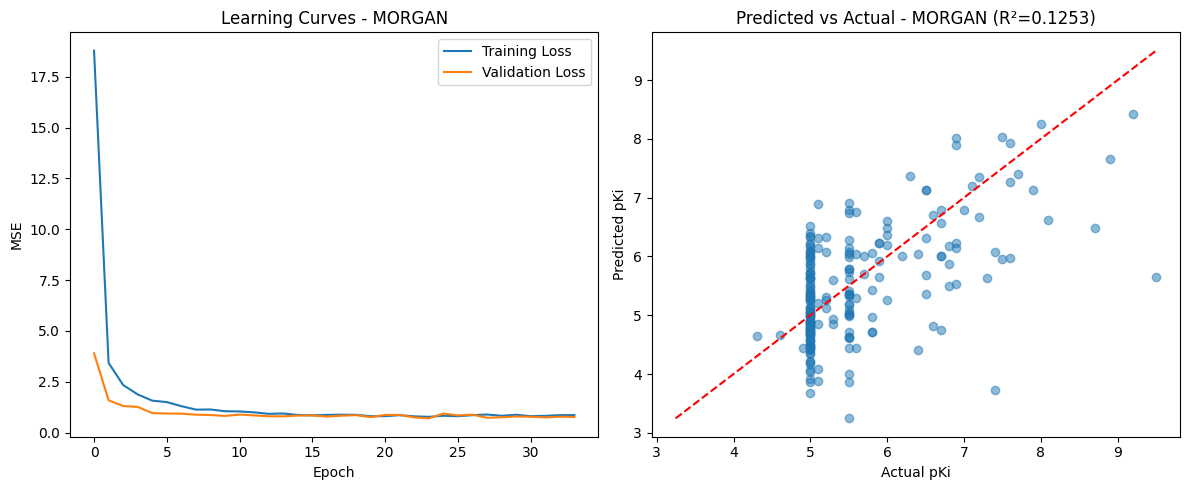


Training model with MORGAN fingerprints
Radius: 3, Bits: 2048


[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerator
[11:41:13] DEPRECATION WARNING: please use MorganGenerat

Time to generate fingerprints: 2.14 seconds
Training set: (830, 2048), Test set: (208, 2048)
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.6944 - mae: 5.0275 - mse: 26.6944

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 26.3947 - mae: 4.9912 - mse: 26.3947 - val_loss: 4.9172 - val_mae: 1.9323 - val_mse: 4.9172
Epoch 2/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8844 - mae: 1.6167 - mse: 3.8844

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8744 - mae: 1.6093 - mse: 3.8744 - val_loss: 1.5383 - val_mae: 1.0012 - val_mse: 1.5383
Epoch 3/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7364 - mae: 1.3520 - mse: 2.7364

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7423 - mae: 1.3532 - mse: 2.7423 - val_loss: 1.5254 - val_mae: 0.9397 - val_mse: 1.5254
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0521 - mae: 1.1415 - mse: 2.0521

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0518 - mae: 1.1410 - mse: 2.0518 - val_loss: 1.0977 - val_mae: 0.7935 - val_mse: 1.0977
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7639 - mae: 1.0704 - mse: 1.7639 - val_loss: 1.1458 - val_mae: 0.7941 - val_mse: 1.1458
Epoch 6/50
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0876 - mae: 1.1292 - mse: 2.0876  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9373 - mae: 1.0982 - mse: 1.9373 - val_loss: 1.0350 - val_mae: 0.7472 - val_mse: 1.0350
Epoch 7/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5495 - mae: 1.0040 - mse: 1.5495

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5466 - mae: 1.0014 - mse: 1.5466 - val_loss: 0.8944 - val_mae: 0.6842 - val_mse: 0.8944
Epoch 8/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3979 - mae: 0.9306 - mse: 1.3979

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3927 - mae: 0.9291 - mse: 1.3927 - val_loss: 0.8701 - val_mae: 0.6783 - val_mse: 0.8701
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2002 - mae: 0.8879 - mse: 1.2002 - val_loss: 1.1106 - val_mae: 0.7893 - val_mse: 1.1106
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2429 - mae: 0.8775 - mse: 1.2429 - val_loss: 1.0424 - val_mae: 0.7616 - val_mse: 1.0424
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1289 - mae: 0.8326 - mse: 1.1289 - val_loss: 0.9750 - val_mae: 0.7262 - val_mse: 0.9750
Epoch 12/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0893 - mae: 0.8372 - mse: 1.0893

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0913 - mae: 0.8353 - mse: 1.0913 - val_loss: 0.7836 - val_mae: 0.6385 - val_mse: 0.7836
Epoch 13/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0160 - mae: 0.8134 - mse: 1.0160

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0300 - mae: 0.8183 - mse: 1.0300 - val_loss: 0.7818 - val_mae: 0.6352 - val_mse: 0.7818
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1942 - mae: 0.8537 - mse: 1.1942 - val_loss: 0.7822 - val_mae: 0.6287 - val_mse: 0.7822
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1752 - mae: 0.8444 - mse: 1.1752 - val_loss: 0.9748 - val_mae: 0.7385 - val_mse: 0.9748
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9089 - mae: 0.7436 - mse: 0.9089 - val_loss: 1.0617 - val_mae: 0.7861 - val_mse: 1.0617
Epoch 17/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0027 - mae: 0.7992 - mse: 1.0027 - val_loss: 0.9573 - val_mae: 0.7354 - val_mse: 0.9573
Epoch 18/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8361 - mae: 0.7267 - mse: 0.8361 - val_loss: 1.1684 - val_mae: 0.8542 - val_mse: 1.1684
Epoch 19/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0245 - mae: 0.7905 - mse: 1.0245 - val_loss: 1.169

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9622 - mae: 0.7820 - mse: 0.9622 - val_loss: 0.7495 - val_mae: 0.6284 - val_mse: 0.7495
Epoch 24/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8593 - mae: 0.7379 - mse: 0.8593 - val_loss: 0.7514 - val_mae: 0.6400 - val_mse: 0.7514
Epoch 25/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0138 - mae: 0.8035 - mse: 1.0138 - val_loss: 0.7829 - val_mae: 0.6580 - val_mse: 0.7829
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8414 - mae: 0.7080 - mse: 0.8414 - val_loss: 0.7788 - val_mae: 0.6565 - val_mse: 0.7788
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8935 - mae: 0.7640 - mse: 0.8935 - val_loss: 0.8104 - val_mae: 0.6537 - val_mse: 0.8104
Epoch 28/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7780 - mae: 0.7097 - mse: 0.7780 - val_loss: 0.8815 - val_mae: 0.6939 - val_mse: 0.8815
Epoch 29/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8302 - mae: 0.7183 - mse: 0.8302 - val_loss: 0.9577


Test MSE: 0.8913
Test MAE: 0.6804
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² Score: -0.0490


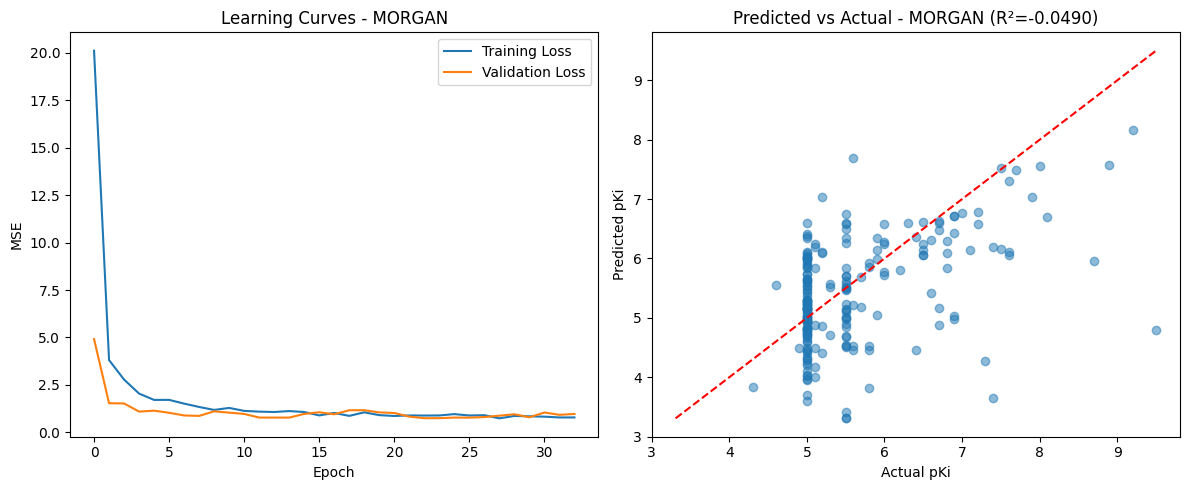


Training model with TOPOLOGICAL fingerprints
Time to generate fingerprints: 4.33 seconds
Training set: (830, 2048), Test set: (208, 2048)
Epoch 1/50
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.2528 - mae: 3.3800 - mse: 17.2528

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 14.5412 - mae: 3.0459 - mse: 14.5412 - val_loss: 2.7342 - val_mae: 1.3641 - val_mse: 2.7342
Epoch 2/50
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2550 - mae: 1.6884 - mse: 4.2550

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.2229 - mae: 1.6788 - mse: 4.2229 - val_loss: 2.4414 - val_mae: 1.2622 - val_mse: 2.4414
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0917 - mae: 1.3699 - mse: 3.0917 - val_loss: 2.6739 - val_mae: 1.3864 - val_mse: 2.6739
Epoch 4/50
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6411 - mae: 1.2668 - mse: 2.6411

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5796 - mae: 1.2513 - mse: 2.5796 - val_loss: 1.5864 - val_mae: 0.9890 - val_mse: 1.5864
Epoch 5/50
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4144 - mae: 1.2419 - mse: 2.4144 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3503 - mae: 1.2174 - mse: 2.3503 - val_loss: 1.0064 - val_mae: 0.7579 - val_mse: 1.0064
Epoch 6/50
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0839 - mae: 1.1122 - mse: 2.0839 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0826 - mae: 1.1179 - mse: 2.0826 - val_loss: 0.9448 - val_mae: 0.7356 - val_mse: 0.9448
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2496 - mae: 1.1686 - mse: 2.2496 - val_loss: 1.1099 - val_mae: 0.8074 - val_mse: 1.1099
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0383 - mae: 1.1347 - mse: 2.0383 - val_loss: 2.6014 - val_mae: 1.4107 - val_mse: 2.6014
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9935 - mae: 1.1126 - mse: 1.9935 - val_loss: 1.4417 - val_mae: 0.9445 - val_mse: 1.4417
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5451 - mae: 0.9598 - mse: 1.5451 - val_loss: 2.0551 - val_mae: 1.2251 - val_mse: 2.0551
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8251 - mae: 1.0375 - mse: 1.8251 - val_loss: 1.6047 - val_mae: 1.0472 - val_mse: 1.6047
Epoch 12/50
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5190 - mae: 0.9853 - mse: 1.5190

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5401 - mae: 0.9902 - mse: 1.5401 - val_loss: 0.8933 - val_mae: 0.6912 - val_mse: 0.8933
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2886 - mae: 0.9243 - mse: 1.2886 - val_loss: 1.8166 - val_mae: 1.1390 - val_mse: 1.8166
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7832 - mae: 1.0490 - mse: 1.7832 - val_loss: 1.8326 - val_mae: 1.1349 - val_mse: 1.8326
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5103 - mae: 0.9400 - mse: 1.5103 - val_loss: 1.4452 - val_mae: 0.9573 - val_mse: 1.4452
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4533 - mae: 0.9519 - mse: 1.4533 - val_loss: 0.9813 - val_mae: 0.7410 - val_mse: 0.9813
Epoch 17/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3655 - mae: 0.9291 - mse: 1.3655 - val_loss: 1.5421 - val_mae: 1.0422 - val_mse: 1.5421
Epoch 18/50
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5896 - mae: 0.9934 - mse: 1.5896

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5553 - mae: 0.9827 - mse: 1.5553 - val_loss: 0.8333 - val_mae: 0.6893 - val_mse: 0.8333
Epoch 19/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2421 - mae: 0.8668 - mse: 1.2421 - val_loss: 0.8823 - val_mae: 0.7229 - val_mse: 0.8823
Epoch 20/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4979 - mae: 0.9510 - mse: 1.4979 - val_loss: 1.0219 - val_mae: 0.7910 - val_mse: 1.0219
Epoch 21/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2592 - mae: 0.8953 - mse: 1.2592 - val_loss: 1.0076 - val_mae: 0.8132 - val_mse: 1.0076
Epoch 22/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3716 - mae: 0.9204 - mse: 1.3716 - val_loss: 1.8526 - val_mae: 1.1599 - val_mse: 1.8526
Epoch 23/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6390 - mae: 0.9996 - mse: 1.6390 - val_loss: 2.0423 - val_mae: 1.2590 - val_mse: 2.0423
Epoch 24/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5324 - mae: 0.9980 - mse: 1.5324 - val_loss: 1.6584 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² Score: -0.0969


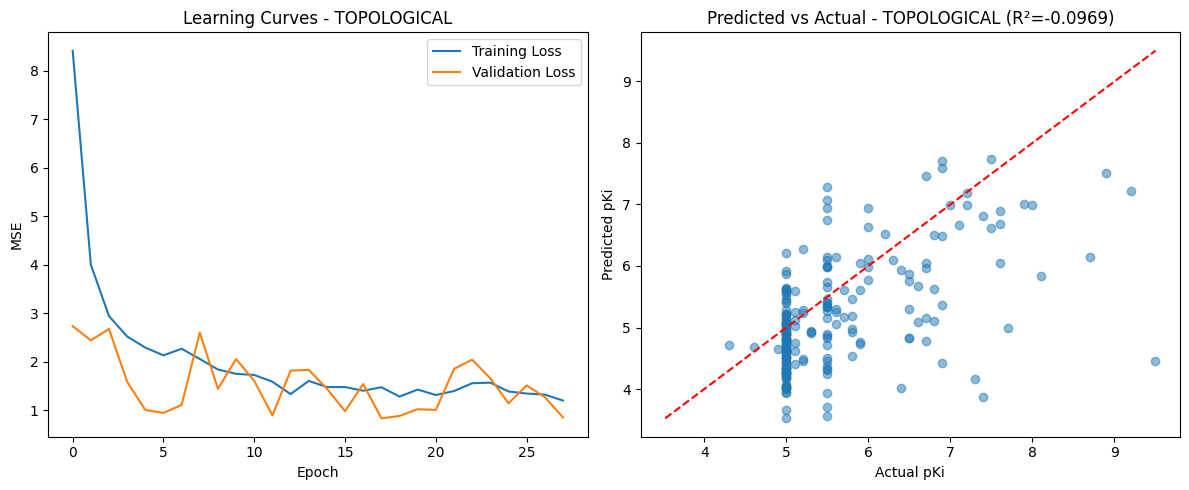

In [22]:
# 1. MACCS Keys (167 bits)
results['maccs'] = train_evaluate_model(fp_type='maccs')

# 2. Morgan Fingerprints (radius 2)
results['morgan_r2'] = train_evaluate_model(fp_type='morgan', radius=2)

# 3. Morgan Fingerprints (radius 3)
results['morgan_r3'] = train_evaluate_model(fp_type='morgan', radius=3)

# 4. Topological Fingerprints (optional)
results['topological'] = train_evaluate_model(fp_type='topological')


In [23]:
# Compare performance metrics
metrics_df = pd.DataFrame({
    'Fingerprint': [k for k in results.keys()],
    'MSE': [results[k]['metrics']['mse'] for k in results.keys()],
    'MAE': [results[k]['metrics']['mae'] for k in results.keys()],
    'R²': [results[k]['metrics']['r2'] for k in results.keys()]
})

print("\nPerformance Comparison:")
print(metrics_df)


Performance Comparison:
   Fingerprint       MSE       MAE        R²
0        maccs  0.752303  0.629294  0.114584
1    morgan_r2  0.743222  0.648444  0.125272
2    morgan_r3  0.891313  0.680391 -0.049022
3  topological  0.931956  0.697512 -0.096856


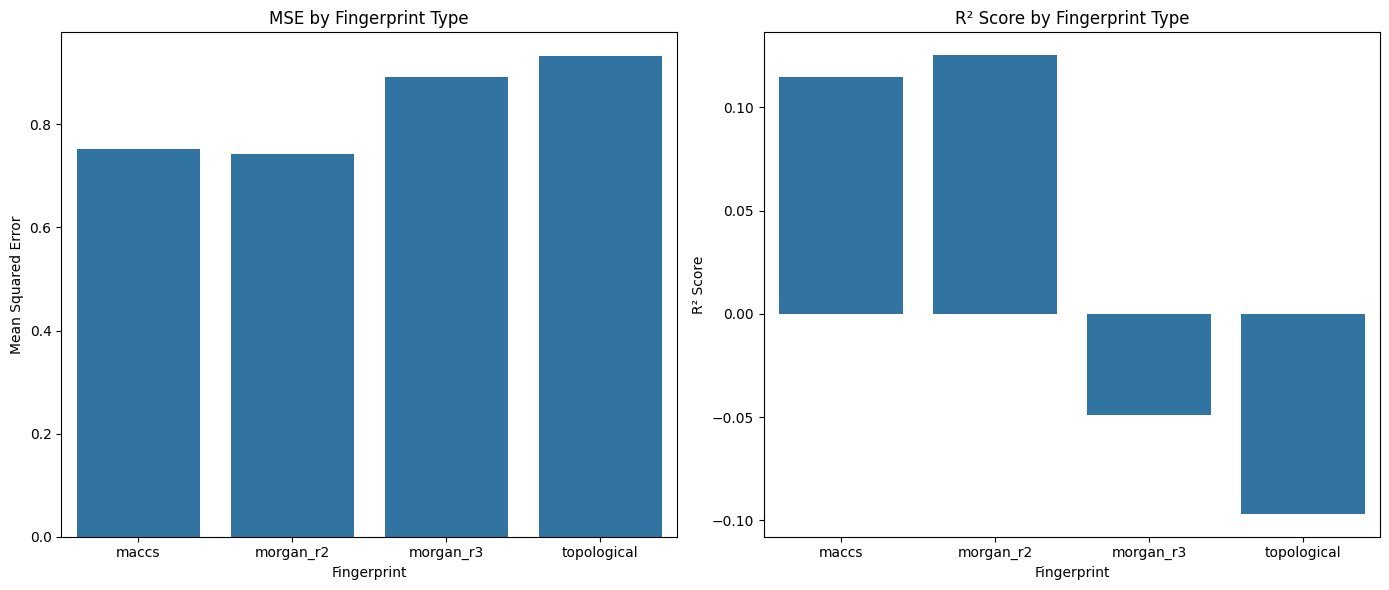

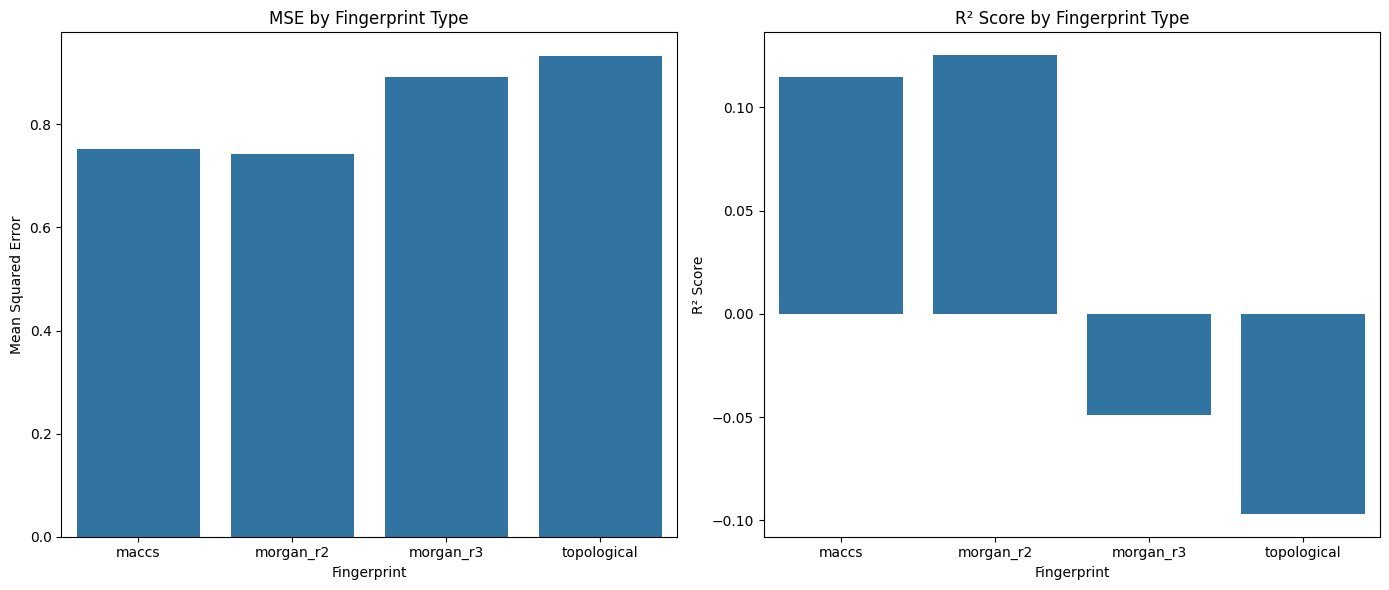

In [24]:
# Plot comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Fingerprint', y='MSE', data=metrics_df)
plt.title('MSE by Fingerprint Type')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
sns.barplot(x='Fingerprint', y='R²', data=metrics_df)
plt.title('R² Score by Fingerprint Type')
plt.ylabel('R² Score')

plt.tight_layout()
plt.savefig("fingerprint_comparison/metrics_comparison.png", dpi=300, bbox_inches="tight")
plt.show()# Plot comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Fingerprint', y='MSE', data=metrics_df)
plt.title('MSE by Fingerprint Type')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
sns.barplot(x='Fingerprint', y='R²', data=metrics_df)
plt.title('R² Score by Fingerprint Type')
plt.ylabel('R² Score')

plt.tight_layout()
plt.savefig("fingerprint_comparison/metrics_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [25]:
# Find the best performing fingerprint type
best_fp = metrics_df.loc[metrics_df['R²'].idxmax(), 'Fingerprint']
print(f"\nBest performing fingerprint: {best_fp} (R²={metrics_df['R²'].max():.4f})")

# Optional: External prediction


Best performing fingerprint: morgan_r2 (R²=0.1253)


In [26]:
# Optional: External prediction
try:
    print("\nLoading external dataset for predictions...")
    external_data = pd.read_csv("enamine.csv")

    # Use the best fingerprint type for prediction
    best_fp_type = best_fp.split('_')[0] if '_' in best_fp else best_fp
    best_radius = int(best_fp.split('_r')[1]) if '_r' in best_fp else 2

    print(f"Generating {best_fp_type} fingerprints for external dataset...")
    external_data['fingerprints'] = external_data['SMILES'].apply(
        lambda x: generate_fingerprint(
            x,
            fp_type=best_fp_type,
            radius=best_radius if best_fp_type == 'morgan' else 2
        )
    )

    # Get the best model
    best_model = results[best_fp]['model']

    # Make predictions
    print("Making predictions on external dataset...")
    X_external = np.array(list(external_data['fingerprints']))
    predictions = best_model.predict(X_external)

    # Add predictions to dataframe
    external_data['predicted_pKi'] = predictions

    print(f"Top 5 predicted compounds:")
    top_compounds = external_data.nlargest(5, 'predicted_pKi')
    print(top_compounds[['SMILES', 'predicted_pKi']])

    # Save predictions
    external_data.to_csv("fingerprint_comparison/external_predictions.csv", index=False)




Loading external dataset for predictions...
Generating morgan fingerprints for external dataset...


Streaming output truncated to the last 5000 lines.
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:46:45] DEPRECATION WARNING: please use MorganGenerator
[11:4

Making predictions on external dataset...
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Top 5 predicted compounds:
                                                  SMILES  predicted_pKi
44960       O=C(Nc1n[nH]c2ccc([N+](=O)[O-])cc12)c1cnccn1       8.965130
34428  N#Cc1c(CCCNC(=O)c2cn(Cc3ccccc3)nc2-c2cccnc2)n[...       8.766082
29535  Cc1nn(CC(F)(F)F)cc1Nc1ncc(C2CC2)c(NCc2ccc(S(N)...       8.693268
29973  Cc1nc(NC(=O)c2cc(-c3ccco3)[nH]n2)sc1Cc1ccc2c(c...       8.400445
11651  N#Cc1c(CCCNC(=O)c2cn(Cc3ccccc3)nc2-c2cccs2)n[n...       8.380939

Visualizing top predicted compounds...
Error in external prediction: write() argument must be str, not SVG


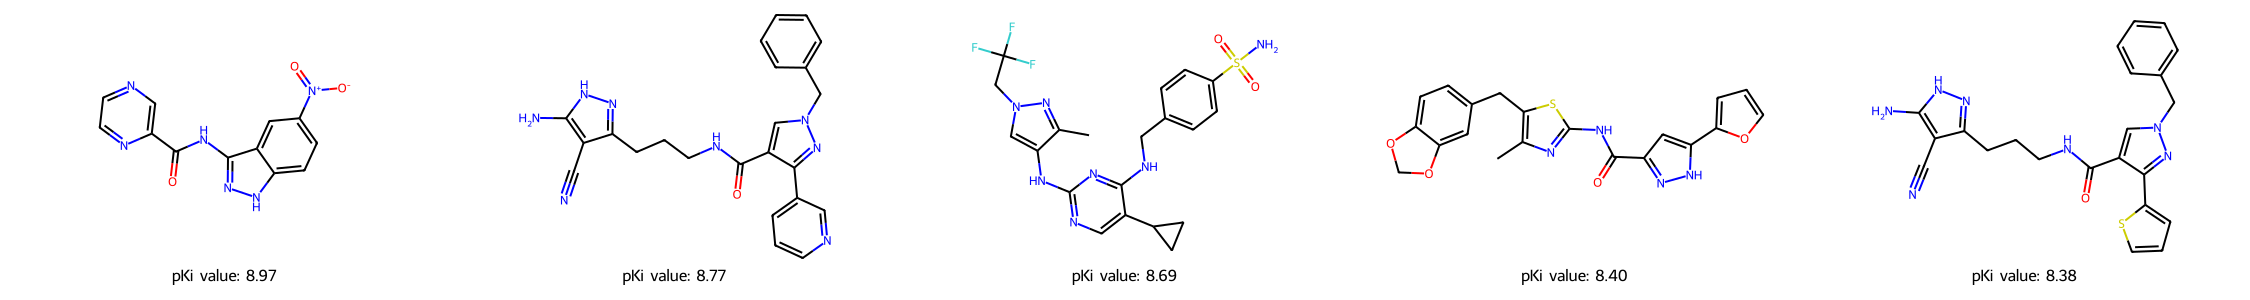

In [34]:
# Draw the drug molecules
# Get predicted pKi values from external_data DataFrame
predicted_pKi_df = external_data.copy()  # Assuming external_data is from the previous cell

# Select the top 5 compounds based on predicted_pKi
top5_drug = predicted_pKi_df.nlargest(5, 'predicted_pKi')

# Get SMILES strings for the top 5 compounds
highest_pKi = predicted_pKi_df["SMILES"][top5_drug.index]

mols_CDK5 = [Chem.MolFromSmiles(smile) for smile in highest_pKi]
pKi_CDK5 = top5_drug["predicted_pKi"].tolist()
# Assuming 'pKi_CDK5' contains the predicted pKi values, and you want to display them as is
pKi_values = [(f"pKi value: {value:.2f}") for value in pKi_CDK5]
# Changed 'pKi-CDK5' to 'pKi_CDK5'

Draw.MolsToGridImage(mols_CDK5, molsPerRow=5, subImgSize=(450, 300), legends=pKi_values)